# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This data represents 17 campaigns taken from May 2008 to November 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, f1_score, PrecisionRecallDisplay, auc as skcauc, precision_recall_curve, roc_curve, RocCurveDisplay
import plotly.express as px
import warnings
import time
import category_encoders as encoder
import warnings

In [120]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [121]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [123]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [124]:
df = df.rename(columns={'y': 'subscribed'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

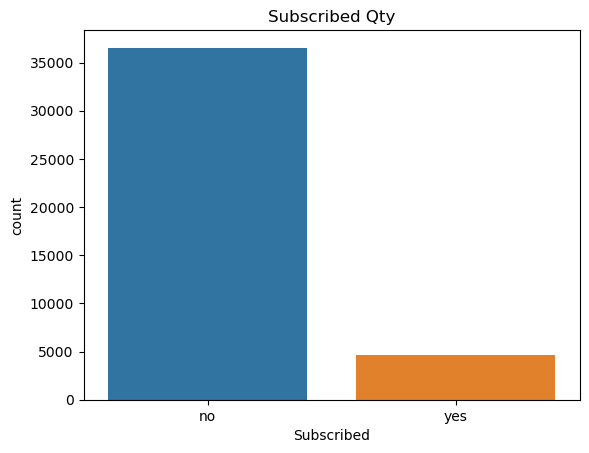

In [125]:
sns.countplot(data = df, x = df["subscribed"]).set_title("Subscribed Qty")
plt.xlabel('Subscribed')
plt.show()

In [153]:
df["subscribed"].value_counts()/df["subscribed"].count()

subscribed
0    0.887346
1    0.112654
Name: count, dtype: float64

The purpose is to predict whether a new customer in a campaign would accept to open a bank account by classifying it according to the characteristics of the analyzed attributes according to the best classification model.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

[Text(0.5, 1.0, 'Features Correlation')]

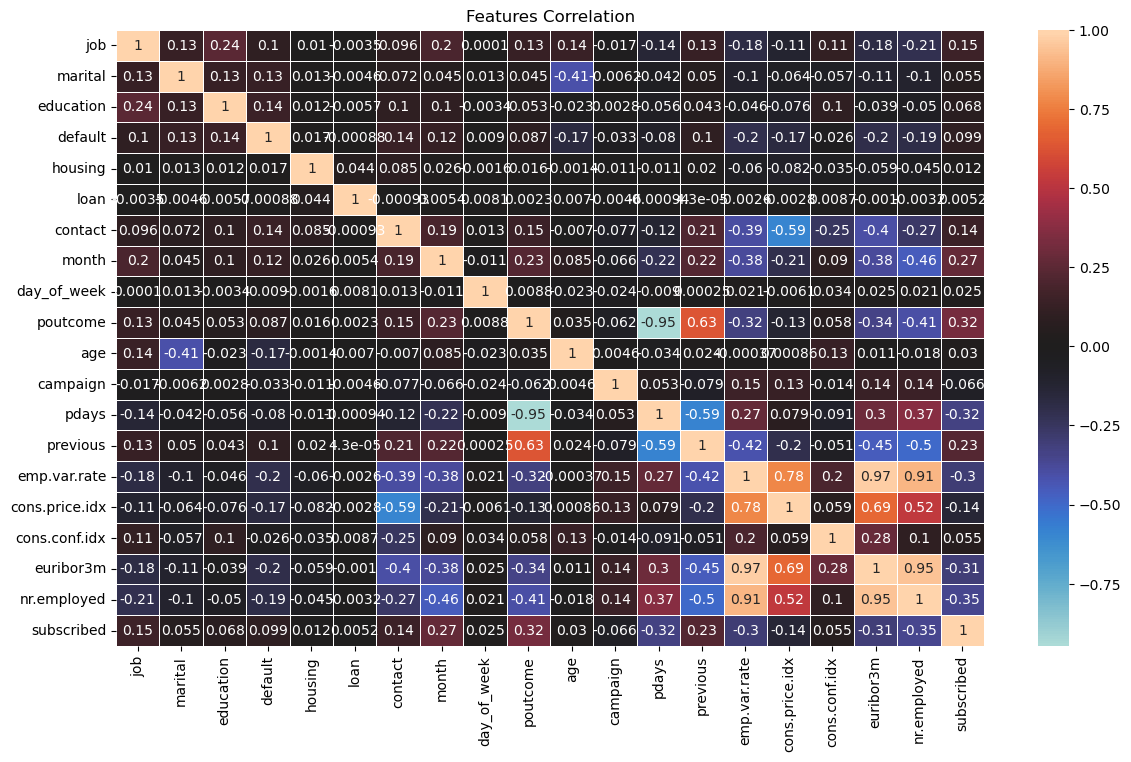

In [150]:
f_cat = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
f_ord = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'subscribed']
trg_enc = ce.TargetEncoder()
df_final = pd.concat(
    [
        trg_enc.fit_transform(df[f_cat], df["subscribed"]), 
        df[f_ord]
    ], 
    axis = 1)
df_final['subscribed'].replace({"yes" : 1, "no": 0}, inplace = True)

# Run the correlation 
corr_data = df_final.corr()

f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_data, center = 0, linewidth = .5, annot = True).set(title='Features Correlation')

In [126]:
def get_unique_values(df,col):
        col_unique_vals = df[col].unique()
        return col_unique_vals

# This function allows to get unique values per columns
def get_feature_unique_values(values_df):
    colList = values_df.dtypes.reset_index()
    # get the features with object type
    cols = colList
    col_unique_val_counter = []
    for colname in cols["index"]:
        col_unique_vals = get_unique_values(values_df, colname)
        col_unique_val_counter.append([colname, len(col_unique_vals)])
        print(colname,col_unique_vals )

    unique_values = pd.DataFrame(col_unique_val_counter)
    unique_values.columns = ['Name', 'Count']
    unique_values = unique_values.sort_values(by='Count', ascending=False).reset_index()

    print(unique_values)

    unique_values.plot(kind='bar', x='Name', y='Count')
    plt.title('Columns With Unique Values')
    plt.grid()
    plt.show()

age [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
job ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital ['married' 'single' 'divorced' 'unknown']
education ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default ['no' 'unknown' 'yes']
housing ['no' 'yes' 'unknown']
loan ['no' 'yes' 'unknown']
contact ['telephone' 'cellular']
subscribed [0 1]
   index        Name  Count
0      0         age     78
1      1         job     12
2      3   education      8
3      2     marital      4
4      4     default      3
5      5     housing      3
6      6        loan      3
7      7     contact      2
8      8  subscribed      2


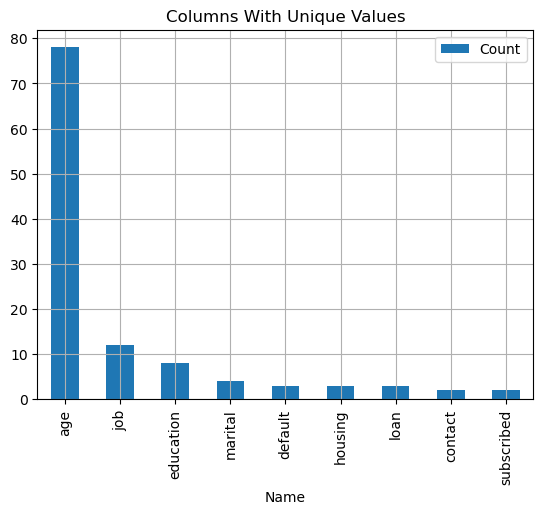

In [151]:
bank_df = df[["age", "job", "marital", "education", "default", "housing", "loan", "contact", "subscribed"]]
get_feature_unique_values(bank_df)

In [128]:
bank_df['subscribed'].replace({"yes" : 1, "no": 0}, inplace = True)
cat_columns = ['job', 'education', 'marital', 'default', 'housing', 'loan', 'contact']

df_encoder = encoder.OrdinalEncoder(cols = cat_columns).fit_transform(bank_df)
df_encoder

/var/folders/gg/gw4jl04x12g83xr72qbsr6mh0000gn/T/ipykernel_43992/796933031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bank_df['subscribed'].replace({"yes" : 1, "no": 0}, inplace = True)


,age,job,marital,education,default,housing,loan,contact,subscribed
0,56,1,1,1,1,1,1,1,0
1,57,2,1,2,2,1,1,1,0
2,37,2,1,2,1,2,1,1,0
3,40,3,1,3,1,1,1,1,0
4,56,2,1,2,1,1,2,1,0
...,...,...,...,...,...,...,...,...,...
41183,73,6,1,5,1,2,1,2,1
41184,46,4,1,5,1,1,1,2,0
41185,56,6,1,7,1,2,1,2,0
41186,44,5,1,5,1,1,1,2,1


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [129]:
X = df_encoder[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact']]
y = df_encoder['subscribed']

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train)
display(y_train)

,age,job,marital,education,default,housing,loan,contact
39075,29,3,1,7,1,1,1,2
34855,29,5,2,7,1,1,1,1
7107,45,4,1,3,2,2,1,1
31614,34,2,1,7,1,1,1,2
34878,32,3,2,2,1,1,1,2
...,...,...,...,...,...,...,...,...
6265,58,6,1,5,2,1,1,1
11284,37,7,1,7,1,1,1,1
38158,35,3,1,2,1,2,1,2
860,40,7,1,7,1,2,1,1


39075    0
34855    0
7107     0
31614    0
34878    0
        ..
6265     0
11284    0
38158    1
860      0
15795    0
Name: subscribed, Length: 28831, dtype: int64

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [131]:
# Create a list and function to save the results
results_list = []
def process_model(key, model_func, X_train, y_train):
    start_time = time.time()
    model = model_func.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # scores
    ps = precision_score(y_test, y_test_pred, zero_division=0)
    rc = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print(f'Precision: {ps}')
    print(f'Recall: {rc}')
    print(f'Accuracy: {test_acc}')
    print(f'F1: {f1}')

    print("The accuracy train {:.2%}".format(train_acc))
    print("The accuracy test {:.2%}".format(test_acc))

    results_list.append({
        'Model': key,
        'Train Time': train_time,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Recall': rc,
        'F1': f1,
        'Precision': ps
    })

    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['No', 'Yes' ])
    disp.plot()
    plt.show()

    return ps, rc, f1, train_acc, test_acc

Precision: 0.0
Recall: 0.0
Accuracy: 0.8875940762320952
F1: 0.0
The accuracy train 88.72%
The accuracy test 88.76%


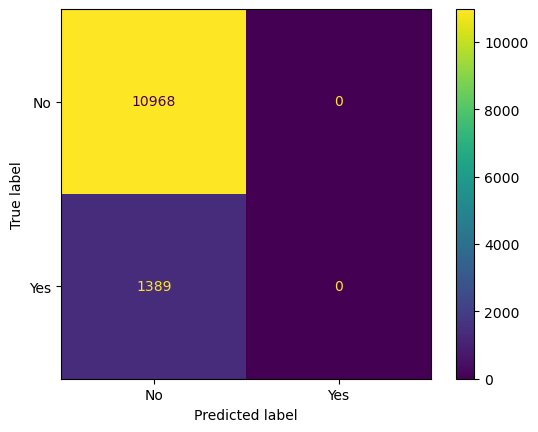

(0.0, 0.0, 0.0, 0.8872394297804447, 0.8875940762320952)

In [132]:
# Use the DummyClassifier
process_model('Dummy', DummyClassifier(strategy= "prior"), X_train, y_train)

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

Precision: 0.0
Recall: 0.0
Accuracy: 0.8875940762320952
F1: 0.0
The accuracy train 88.72%
The accuracy test 88.76%


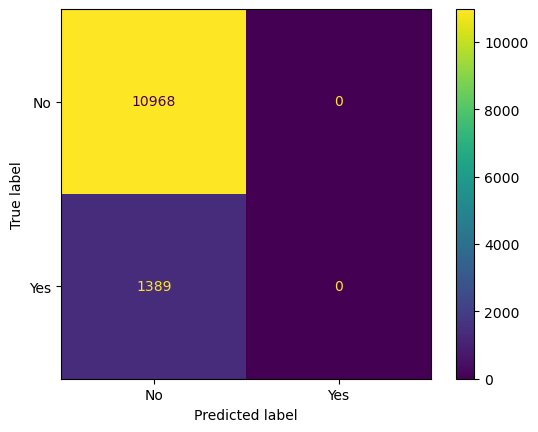

(0.0, 0.0, 0.0, 0.8872394297804447, 0.8875940762320952)

In [133]:
#Use a simple model Logistic Regression
result_lr = process_model('Logistic Regression', LogisticRegression(max_iter=5000), X_train, y_train)
result_lr

### Problem 9: Score the Model

What is the accuracy of your model?

In [134]:
result_lr

print("Accurrancy score for the logistic regressor for train data is {:.2%}".format(result_lr[3]))
print("Accurrancy score for the logistic regressor for test data is {:.2%}".format(result_lr[4]))

Accurrancy score for the logistic regressor for train data is 88.72%
Accurrancy score for the logistic regressor for test data is 88.76%


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### KNN

Precision: 0.3141025641025641
Recall: 0.07055435565154787
Accuracy: 0.8782066844703407
F1: 0.11522633744855966
The accuracy train 89.30%
The accuracy test 87.82%


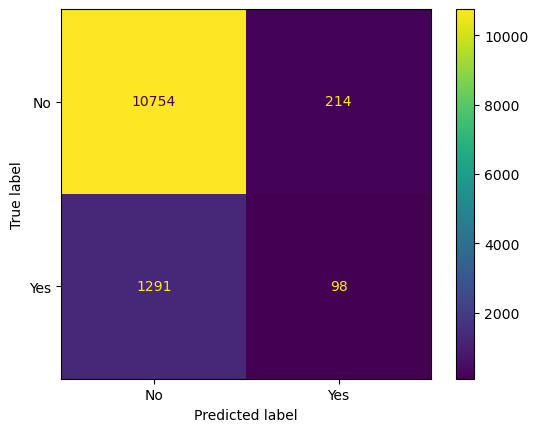

(0.3141025641025641,
 0.07055435565154787,
 0.11522633744855966,
 0.8929624362665187,
 0.8782066844703407)

In [135]:
process_model('KNN',KNeighborsClassifier(), X_train, y_train )

### Decision Tree

Precision: 0.22305389221556887
Recall: 0.10727141828653708
Accuracy: 0.8576515335437404
F1: 0.14487117160913954
The accuracy train 92.56%
The accuracy test 85.77%


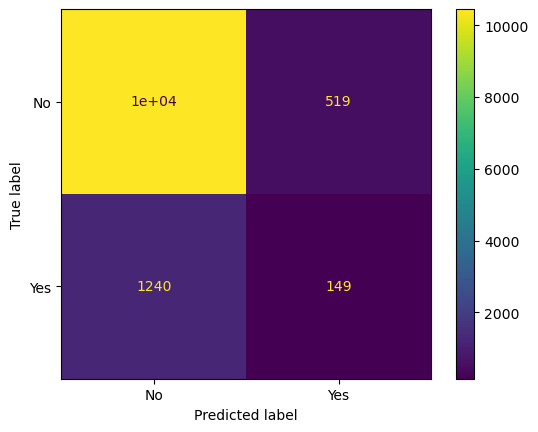

(0.22305389221556887,
 0.10727141828653708,
 0.14487117160913954,
 0.9256356005688322,
 0.8576515335437404)

In [136]:
process_model('DecisionTreeClassifier',DecisionTreeClassifier(), X_train, y_train )

### SVM



Precision: 0.0
Recall: 0.0
Accuracy: 0.8875940762320952
F1: 0.0
The accuracy train 88.72%
The accuracy test 88.76%


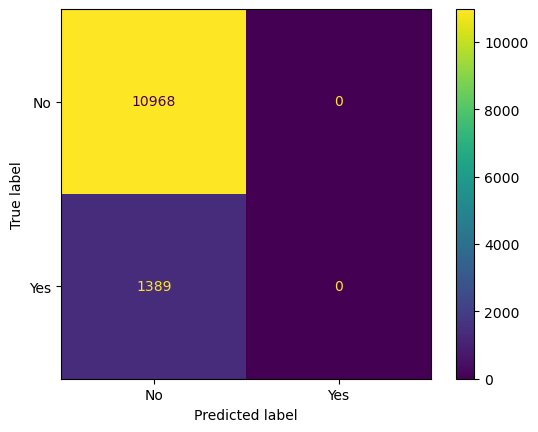

(0.0, 0.0, 0.0, 0.8872394297804447, 0.8875940762320952)

In [137]:
process_model('SVM',SVC(), X_train, y_train )

In [138]:
results_df = pd.DataFrame(results_list).set_index('Model').sort_values(by='Test Accuracy', ascending=False)
results_df

,Train Time,Train Accuracy,Test Accuracy,Recall,F1,Precision
Model,,,,,,
Dummy,0.002306,0.887239,0.887594,0.000000,0.000000,0.000000
Logistic Regression,3.594868,0.887239,0.887594,0.000000,0.000000,0.000000
SVM,3.058259,0.887239,0.887594,0.000000,0.000000,0.000000
KNN,0.014549,0.892962,0.878207,0.070554,0.115226,0.314103
DecisionTreeClassifier,0.116108,0.925636,0.857652,0.107271,0.144871,0.223054


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [139]:
df['subscribed'].replace({"yes" : 1, "no": 0}, inplace = True)
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


[Text(0.5, 1.0, 'Features Correlation')]

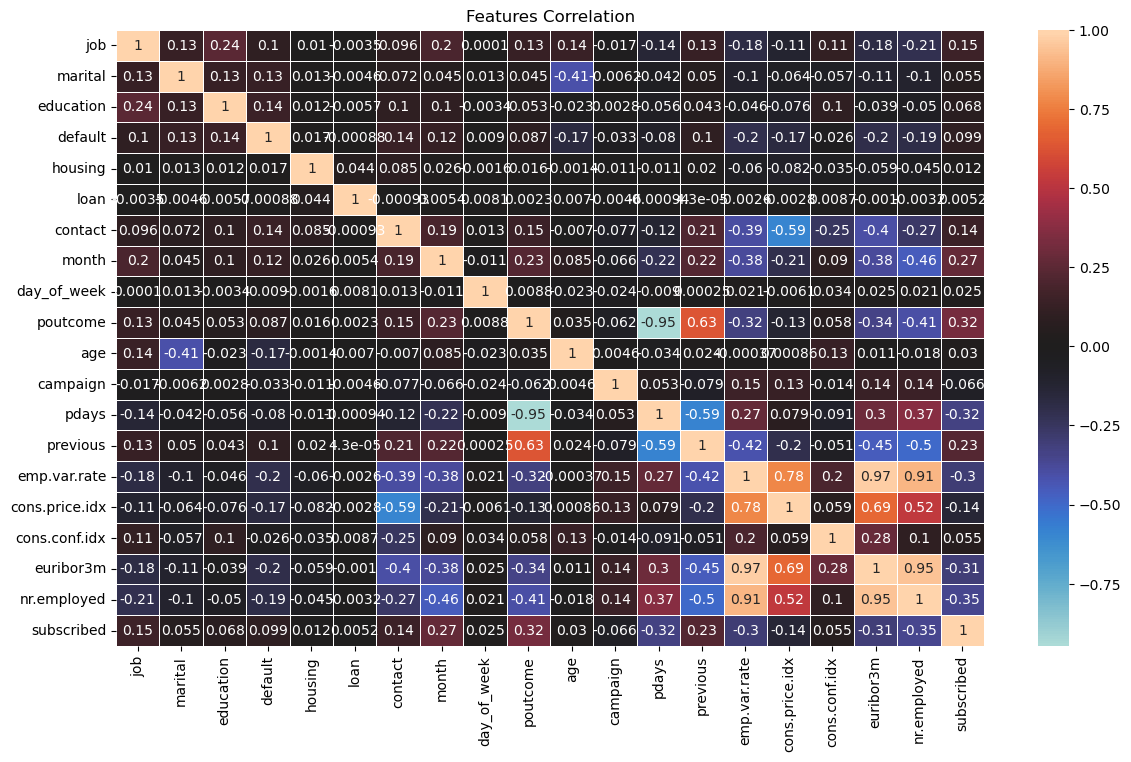

In [140]:
f_cat = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
f_ord = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'subscribed']
trg_enc = ce.TargetEncoder()
df_final = pd.concat(
    [
        trg_enc.fit_transform(df[f_cat], df["subscribed"]), 
        df[f_ord]
    ], 
    axis = 1)
df_final['subscribed'].replace({"yes" : 1, "no": 0}, inplace = True)

# Run the correlation 
corr_data = df_final.corr()

f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_data, center = 0, linewidth = .5, annot = True).set(title='Features Correlation')

we found characteristics with high correlations which we will remove from the dataset to have a better estimation. 
* emp.var.rate
* cons.price.idx
* nr.employed

[Text(0.5, 1.0, 'Features Correlation')]

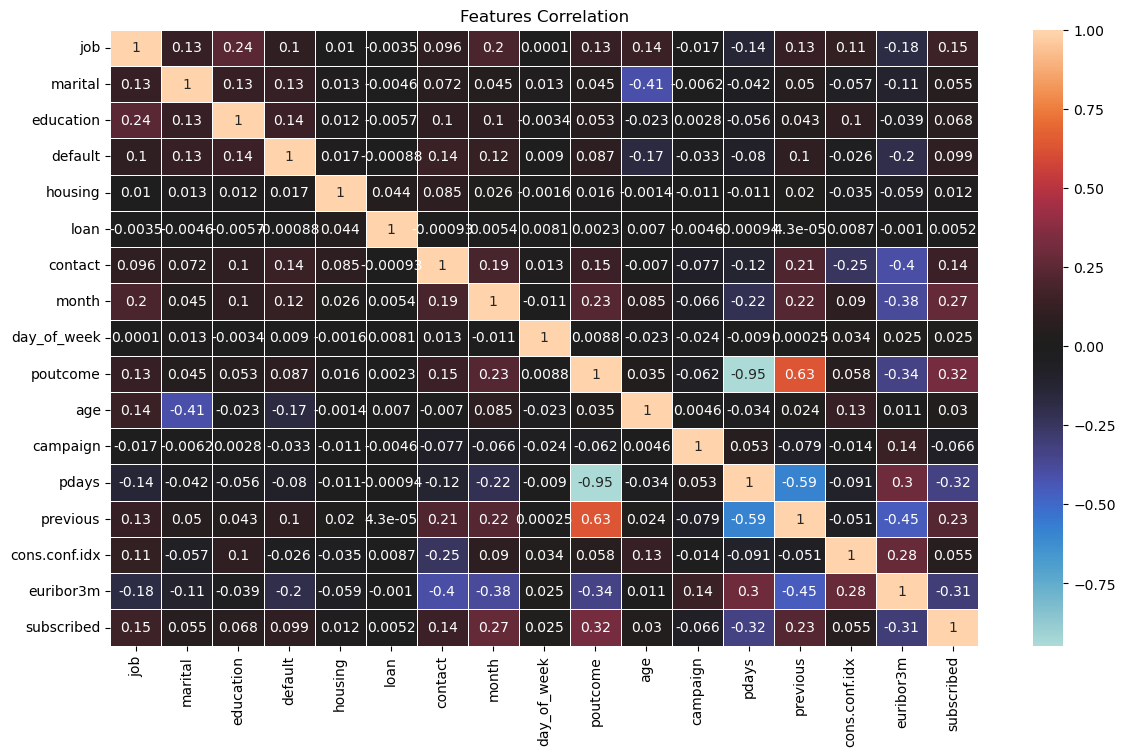

In [141]:
# print correlations
f_cat = ['job' , 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
f_ord = ['age', 'campaign', 'pdays', 'previous', 'cons.conf.idx', 'euribor3m','subscribed']
trg_enc = ce.TargetEncoder()
df_final = pd.concat(
    [
        trg_enc.fit_transform(df[f_cat], df["subscribed"]), 
        df[f_ord]
    ], 
    axis = 1)
df_final['subscribed'].replace({"yes" : 1, "no": 0}, inplace = True)

# Run the correlation 
corr_data = df_final.corr()

f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_data, center = 0, linewidth = .5, annot = True).set(title='Features Correlation')

In [142]:
X = df_final.drop(['subscribed'], axis = 1)
y = df_final['subscribed']

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train)
display(y_train)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age,campaign,pdays,previous,cons.conf.idx,euribor3m
39075,0.129726,0.101573,0.137245,0.12879,0.108796,0.113402,0.147376,0.489011,0.099483,0.142286,29,3,999,1,-33.0,0.709
34855,0.108260,0.140041,0.137245,0.12879,0.108796,0.113402,0.052313,0.064347,0.108087,0.088322,29,4,999,0,-46.2,1.250
7107,0.068943,0.101573,0.082024,0.05153,0.116194,0.113402,0.052313,0.064347,0.121188,0.088322,45,2,999,0,-36.4,4.860
31614,0.081381,0.101573,0.137245,0.12879,0.108796,0.113402,0.147376,0.064347,0.121188,0.142286,34,1,999,1,-46.2,1.327
34878,0.129726,0.140041,0.108355,0.12879,0.108796,0.113402,0.147376,0.064347,0.108087,0.088322,32,9,999,0,-46.2,1.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6265,0.252326,0.101573,0.113485,0.05153,0.108796,0.113402,0.052313,0.064347,0.117800,0.088322,58,2,999,0,-36.4,4.857
11284,0.112175,0.101573,0.137245,0.12879,0.108796,0.113402,0.052313,0.105115,0.121188,0.088322,37,1,999,0,-41.8,4.961
38158,0.129726,0.101573,0.108355,0.12879,0.116194,0.113402,0.147376,0.438719,0.121188,0.651129,35,1,4,1,-26.9,0.754
860,0.112175,0.101573,0.137245,0.12879,0.116194,0.113402,0.052313,0.064347,0.116671,0.088322,40,2,999,0,-36.4,4.856


39075    0
34855    0
7107     0
31614    0
34878    0
        ..
6265     0
11284    0
38158    1
860      0
15795    0
Name: subscribed, Length: 28831, dtype: int64

In [144]:
def process_model_grid(key, model_func, X_train, y_train, X_test, y_test):

    start_time = time.time()
    model = model_func.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_train_pred = model.best_estimator_.predict(X_train)
    y_test_pred = model.best_estimator_.predict(X_test)
    
    # scores
    ps = precision_score(y_test, y_test_pred, zero_division=0)
    rc = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    train_acc = model.best_estimator_.score(X_train, y_train)
    test_acc =  model.best_estimator_.score(X_test, y_test)

    print(f'Precision: {ps}')
    print(f'Recall: {rc}')
    print(f'Accuracy: {test_acc}')
    print(f'F1: {f1}')
    print(model_func.best_estimator_)

    print("The accuracy train {:.2%}".format(train_acc))
    print("The accuracy test {:.2%}".format(test_acc))

    results_list.append({
        'Model': key,
        'Train Time': train_time,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Recall': rc,
        'F1': f1,
        'Precision': ps
    })

    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['No', 'Yes' ])
    disp.plot()
    plt.show()

    return ps, rc, f1, train_acc, test_acc, train_time

Precision: 0.6350210970464135
Recall: 0.21670266378689704
Accuracy: 0.897952577486445
F1: 0.3231347289318304
Pipeline(steps=[('scaler', StandardScaler()), ('lr', LogisticRegression())])
The accuracy train 89.76%
The accuracy test 89.80%


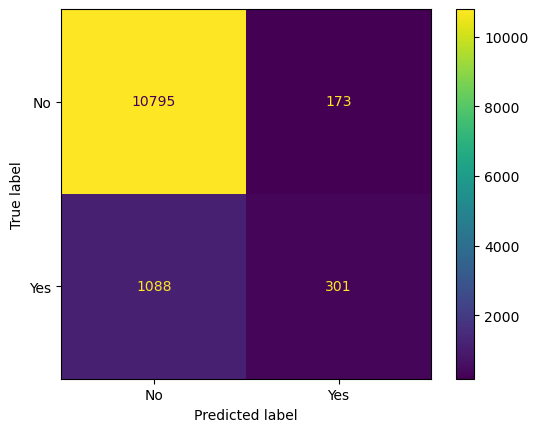

(0.6350210970464135,
 0.21670266378689704,
 0.3231347289318304,
 0.8976448961187611,
 0.897952577486445,
 4.700716018676758)

In [145]:
param_grid_log = {
    'lr__solver': ['lbfgs', 'liblinear'],
    'lr__max_iter': [100, 200, 300,1000]  
}

pipe_logistic = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])
process_model_grid('Logistic Regression Grid', GridSearchCV(estimator=pipe_logistic, param_grid=param_grid_log, cv=5), X_train, y_train, X_test, y_test)

Precision: 0.6145833333333334
Recall: 0.21238300935925125
Accuracy: 0.896495913247552
F1: 0.31567683253076506
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=20, p=1))])
The accuracy train 90.35%
The accuracy test 89.65%


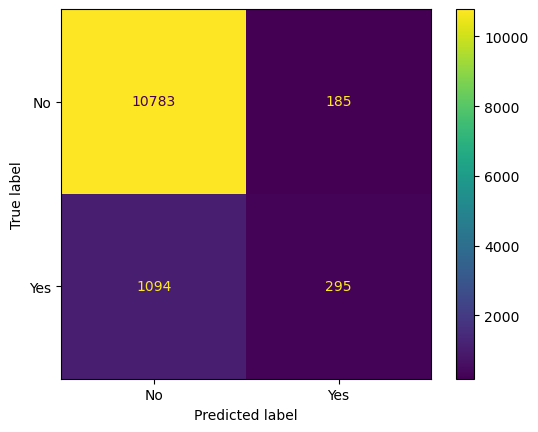

(0.6145833333333334,
 0.21238300935925125,
 0.31567683253076506,
 0.9034719572682183,
 0.896495913247552,
 57.17883801460266)

In [146]:
param_grid_knn = {
    'knn__n_neighbors': list(range(1, 22, 1)),
    'knn__weights': ['uniform'],
    'knn__p': [1, 2]
}

pipe_KNN = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
process_model_grid('KNN Grid', GridSearchCV(estimator=pipe_KNN, param_grid=param_grid_knn, cv=5), X_train, y_train, X_test, y_test)

Precision: 0.6136363636363636
Recall: 0.27213822894168466
Accuracy: 0.8989236869790402
F1: 0.37705735660847883
Pipeline(steps=[('scaler', StandardScaler()),
                ('d_tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5))])
The accuracy train 90.31%
The accuracy test 89.89%


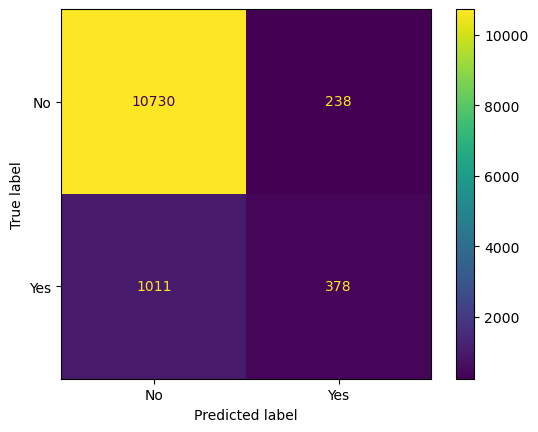

(0.6136363636363636,
 0.27213822894168466,
 0.37705735660847883,
 0.9030557386146856,
 0.8989236869790402,
 33.25467586517334)

In [147]:
param_grid_decision_tree = {
    'd_tree__max_depth': [None, 5, 10, 15, 20],
    'd_tree__min_samples_split': [2, 4,8,10],
    'd_tree__criterion': ['gini', 'entropy'],
    'd_tree__min_samples_leaf': [1, 2, 3]
}


pipe_decision_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('d_tree', DecisionTreeClassifier())
])

process_model_grid('DecisionTreeClassifier Grid', GridSearchCV(estimator=pipe_decision_tree, param_grid=param_grid_decision_tree, cv=5), X_train, y_train, X_test, y_test)

/Users/ronalcamilocuellar/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ronalcamilocuellar/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ronalcamilocuellar/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ronalcamilocuellar/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ronalcamilocuellar/anacon

Precision: 0.6197478991596639
Recall: 0.21238300935925125
Accuracy: 0.8968196164117505
F1: 0.3163538873994638
Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(gamma=0.1, kernel='linear', max_iter=10000,
                     probability=True))])
The accuracy train 89.78%
The accuracy test 89.68%


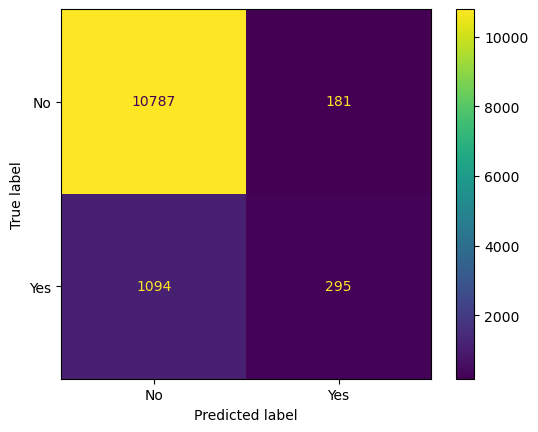

(0.6197478991596639,
 0.21238300935925125,
 0.3163538873994638,
 0.897818320557733,
 0.8968196164117505,
 283.9425814151764)

In [148]:
param_grid_svc = {'svc__kernel': ['poly', 'linear'],
         'svc__gamma': [0.1, 1.0]}

pipe_SVC = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability =True, max_iter =10000))
])

process_model_grid('SVM Grid', GridSearchCV(estimator=pipe_SVC, param_grid=param_grid_svc, cv=5), X_train, y_train, X_test, y_test)

In [149]:

results_df = pd.DataFrame(results_list).set_index('Model')
results_df.sort_values("Test Accuracy", ascending=False).reset_index()

,Model,Train Time,Train Accuracy,Test Accuracy,Recall,F1,Precision
0,DecisionTreeClassifier Grid,33.254676,0.903056,0.898924,0.272138,0.377057,0.613636
1,Logistic Regression Grid,4.700716,0.897645,0.897953,0.216703,0.323135,0.635021
2,SVM Grid,283.942581,0.897818,0.896820,0.212383,0.316354,0.619748
3,KNN Grid,57.178838,0.903472,0.896496,0.212383,0.315677,0.614583
4,Dummy,0.002306,0.887239,0.887594,0.000000,0.000000,0.000000
5,Logistic Regression,3.594868,0.887239,0.887594,0.000000,0.000000,0.000000
6,SVM,3.058259,0.887239,0.887594,0.000000,0.000000,0.000000
7,KNN,0.014549,0.892962,0.878207,0.070554,0.115226,0.314103
8,DecisionTreeClassifier,0.116108,0.925636,0.857652,0.107271,0.144871,0.223054


##### Questions